# Website Content Prediction

In this project we're taking some data on customer's spending habits to predict whether or not they will click on a specific content on a website.

As usual, we start with some data exploration, before moving onto some cleaning, feature scaling, Principal Component Analysis, sampling and finally modelling. 

We'll be using a stacked generalisation ensemble method for classification, which is a pretty common method to find in high performing Kaggle competitions these days. 

I'll go into what this is in a little more depth when we get to that stage, but for now let's import the usual suspects and get analysing.

## EDA and Feature Engineering

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from mlxtend.classifier import StackingCVClassifier

from sklearn.metrics import roc_auc_score, recall_score, precision_score, accuracy_score

In [3]:
df = pd.read_csv('input/content_train.csv')

print(df.shape)
df.head()

(100000, 27)


,customer_id,content_1,content_2,content_3,content_4,content_5,content_6,content_7,content_8,content_9,...,store4_total_spend,store5_no_transactions,store5_total_spend,store6_no_transactions,store6_total_spend,store7_no_transactions,store7_total_spend,gender,affluency,county
0,1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,...,634.11,14,76.12,32,753.12,10,617.47,Female,Mid,Surrey
1,2,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,...,679.78,13,142.74,28,37.86,51,2787.49,Female,Mid,Greater Manchester
2,3,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,...,282.90,7,672.12,55,563.12,4,444.34,Female,Low,Greater Manchester
3,4,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,0.0,...,5954.89,49,2394.10,56,912.70,24,5859.31,Male,Mid,Brighton & Hove
4,5,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,...,3170.40,27,651.36,52,925.30,17,433.57,Female,Low,Norfolk


We'll remove the id feature, and we'll need to choose which content to work with for this project (for ease, we'll pick the one with least NaNs). 

NaNs will likely be appearing for customers to whom have not had the content shown to them.

In [4]:
df.drop('customer_id', axis=1, inplace=True)
content_cols = ['content_1','content_2','content_3','content_4','content_5','content_6','content_7','content_8','content_9',]
df_content_cols = df[content_cols]

not_null_pct = pd.DataFrame(df_content_cols.count() / len(df_content_cols) * 100, columns=['% not null'])
balance_pct = pd.DataFrame(df_content_cols.sum() / len(df_content_cols) * 100, columns=['% balance'])

df_na_balance = pd.concat([not_null_pct, balance_pct], axis=1)
df_na_balance

,% not null,% balance
content_1,46.022,0.502
content_2,42.958,0.509
content_3,27.314,0.975
content_4,38.079,1.096
content_5,44.830,0.793
content_6,49.706,0.156
content_7,38.196,0.201
content_8,38.346,0.210
content_9,48.025,0.349


Some HEAVY class imbalance here. We're going to have to try some sampling methods to get over this, but this looks like it'll be a tricky one to solve!

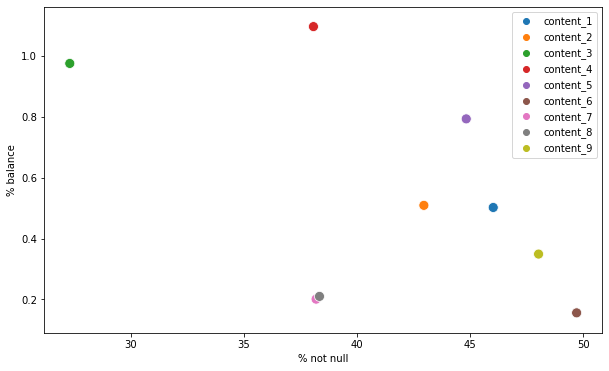

In [5]:
plt.figure(figsize=(10,6))
sns.scatterplot(df_na_balance['% not null'], df_na_balance['% balance'], hue=df_na_balance.index, s=100)
plt.show()

To make matters worse, the content with high amounts of NaNs, also are the ones with higher class balance... So we'll take the content that shows highest in the top-right quadrant: content_5.

In [6]:
cols_remove = ['content_1','content_2','content_3','content_4','content_6','content_7','content_8','content_9']
df.drop(cols_remove, axis=1, inplace=True)

In [7]:
df = df.dropna().reset_index(drop=True)
print(df.shape)

(44830, 18)


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44830 entries, 0 to 44829
Data columns (total 18 columns):
content_5                 44830 non-null float64
store1_no_transactions    44830 non-null int64
store1_total_spend        44830 non-null float64
store2_no_transactions    44830 non-null int64
store2_total_spend        44830 non-null float64
store3_no_transactions    44830 non-null int64
store3_total_spend        44830 non-null float64
store4_no_transactions    44830 non-null int64
store4_total_spend        44830 non-null float64
store5_no_transactions    44830 non-null int64
store5_total_spend        44830 non-null float64
store6_no_transactions    44830 non-null int64
store6_total_spend        44830 non-null float64
store7_no_transactions    44830 non-null int64
store7_total_spend        44830 non-null float64
gender                    44830 non-null object
affluency                 44830 non-null object
county                    44830 non-null object
dtypes: float64(8), int64(

There are 3 categorical features in there that we'll need to sort out. County in particular looks like it'll need some particular attention.

Let's take a look at our numerical features first though.

In [9]:
df.describe()

,content_5,store1_no_transactions,store1_total_spend,store2_no_transactions,store2_total_spend,store3_no_transactions,store3_total_spend,store4_no_transactions,store4_total_spend,store5_no_transactions,store5_total_spend,store6_no_transactions,store6_total_spend,store7_no_transactions,store7_total_spend
count,44830.000000,44830.000000,44830.000000,44830.000000,44830.000000,44830.000000,44830.000000,44830.000000,44830.000000,44830.000000,44830.000000,44830.000000,44830.000000,44830.000000,44830.000000
mean,0.017689,49.938746,770.204315,50.082623,1151.190058,50.108209,2833.789122,49.719563,2815.363340,30.512603,1043.910412,30.342628,571.474093,30.527705,2826.470097
std,0.131820,19.019645,896.816767,19.253655,1349.516816,18.954799,3365.743117,19.042009,3334.423549,18.248171,1411.712431,18.143823,776.658712,18.213927,3786.695710
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,37.000000,205.670000,37.000000,310.512500,37.000000,756.205000,37.000000,754.387500,17.000000,189.502500,17.000000,105.372500,17.000000,511.705000
50%,0.000000,50.000000,493.815000,50.000000,737.150000,50.000000,1801.625000,50.000000,1786.465000,30.000000,587.525000,30.000000,321.900000,30.000000,1564.250000
75%,0.000000,63.000000,1006.700000,63.000000,1486.950000,63.000000,3677.585000,63.000000,3677.035000,43.000000,1359.060000,43.000000,736.947500,43.000000,3672.542500
max,1.000000,139.000000,13822.610000,140.000000,22317.430000,131.000000,73988.490000,129.000000,82972.690000,116.000000,40018.310000,124.000000,14822.620000,118.000000,65821.180000


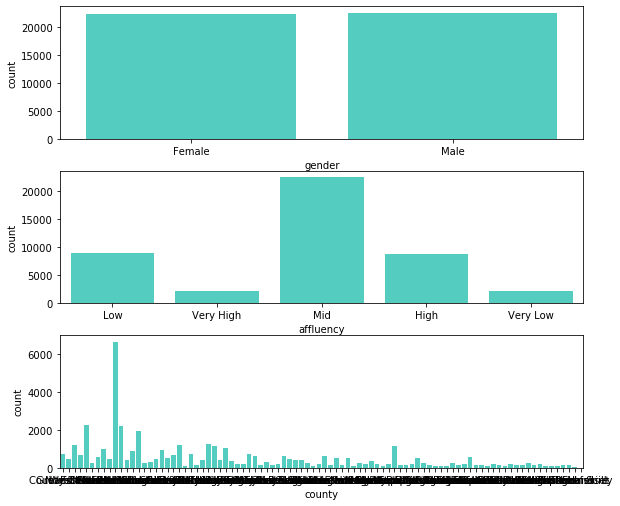

In [10]:
df_categorical = df.select_dtypes(include='object')
fig, ax = plt.subplots(3,1,figsize = (8,7))
fig.tight_layout()
for i, feature in enumerate(df_categorical.columns):
    plot = sns.countplot(df_categorical[feature], color='turquoise', ax=ax[i], )
fig.show()

We can just create scales for gender and affluency, but we'll need to encode the county. But since there are so many, we may have to lookup to a higher geospatial granularity, or even remove the feature entirely.

In [11]:
# 1 if female, 0 if male
gender_encode_dict = dict(zip(df['gender'].unique(), [1,0]))
# Ordinal scale for affluency
affluency_encode_dict = dict(zip(df['affluency'].unique(), [2,1,0,3,4]))

In [12]:
df = df.replace({'gender': gender_encode_dict})
df = df.replace({'affluency': affluency_encode_dict})
df.head()

,content_5,store1_no_transactions,store1_total_spend,store2_no_transactions,store2_total_spend,store3_no_transactions,store3_total_spend,store4_no_transactions,store4_total_spend,store5_no_transactions,store5_total_spend,store6_no_transactions,store6_total_spend,store7_no_transactions,store7_total_spend,gender,affluency,county
0,0.0,38,143.67,39,601.60,39,856.57,52,3170.40,27,651.36,52,925.30,17,433.57,1,2,Norfolk
1,0.0,56,1947.77,45,2460.47,51,9436.17,33,573.02,0,0.00,0,0.00,32,3342.85,1,1,County Durham
2,0.0,29,2441.30,57,648.95,55,9695.78,86,8386.47,23,2.28,19,327.66,26,1436.20,1,0,Essex
3,0.0,28,602.62,10,756.95,81,2629.97,56,687.44,48,702.18,55,140.50,0,0.00,0,0,West Sussex
4,0.0,54,1128.71,31,6.20,16,138.16,43,5160.10,36,958.01,34,20.65,24,468.64,0,0,Greater Manchester


In [13]:
county_lookup = pd.read_csv('input/uk-counties-to-regions.csv')
county_lookup.head(2)

,county,region
0,Guernsey,Crown Dependencies
1,IOM,Crown Dependencies


In [14]:
df = df.merge(county_lookup, how='inner').drop('county', axis=1)
print('df shape: {}'.format(df.shape))
print('Number of unique regions: {}'.format(len(df['region'].unique())))
print('Number of NaNs in region: {}'.format(sum(df['region'].isna())))

df shape: (58417, 18)
Number of unique regions: 9
Number of NaNs in region: 0


We'll remove those NA values resulting from the merge, as it's not too much. And 10 dummy variables shouldn't be too bad I feel. I'm sure we will work with it more in our PCA work.

In [15]:
df.dropna(inplace=True)
def dummies(df, columns):
    for column in columns:
        df[column] = df[column].apply(lambda x: str(x))
        df = pd.concat((df, pd.get_dummies(df[column], prefix = column)), axis = 1)
        df = df.drop(column, 1)
    return df

In [16]:
df = dummies(df, ['region'])

It's always hepful at this point to check out the correlations of all the variables, so we can be aware of any highly correlated features (correlations outside of the target variable, that is).

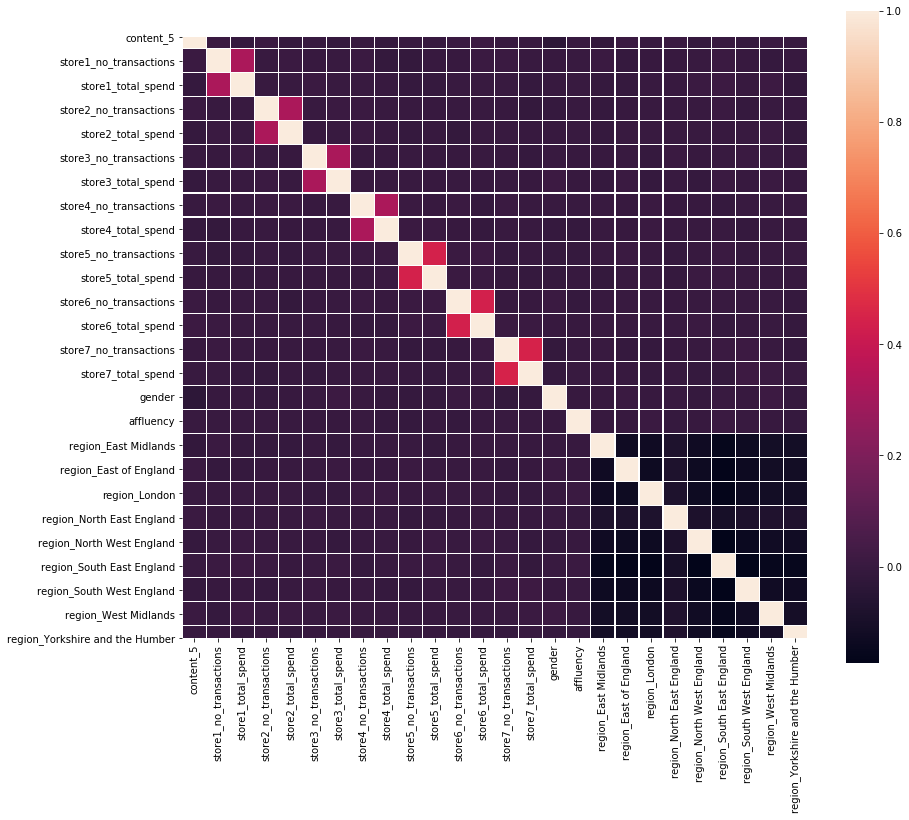

In [17]:
plt.figure(figsize=(14,12))
sns.heatmap(df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True)
plt.show()

Looks good! I was worried that the no. transactions and total transaction features were going to be highly correlated, in which case we'd have to work through that... But thankfully not today. 

Highly correlated features aren't necessarily a bad thing, but they can be quite fiddly for feature selection. Often we need to remove a selection of the correlated features as they can be expensive to keep in, but the boundary of what to keep and what to throw is hard to define, and hence, fiddly. 

## Feature Scaling & Sampling

In [18]:
X = df.loc[:, df.columns != 'content_5']
y = df['content_5']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 10)

#train = pd.concat([X_train, y_train], axis=1)
#test = pd.concat([X_test, y_test], axis=1)

In [19]:
overfit = []
for i in X_train.columns:
    counts = X_train[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X_train) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
print(overfit)
X_train = X_train.drop(overfit, axis=1)
print(X_train.shape)

[]
(46733, 25)


We don't need to get rid of any features that may cause overfitting according to the above check, which is promising.

Now we need to address the class imbalance that's been hanging over my head... We'll do a mixture of undersampling (removing records to address the imbalance), and Synthetic Minority Over Sampling.

In [20]:
rus = RandomUnderSampler(ratio=0.5, random_state=10)
X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)
print(X_train_rus.shape)

(2373, 25)


In [21]:
sm = SMOTE(ratio=1, random_state = 10)
X_train_res, y_train_res = sm.fit_sample(X_train_rus, y_train_rus)

In [22]:
print("Before Sampling:")
print("---------------------")
print("X_train: {} records".format(str(len(X_train))))
print("y_train: {} records".format(str(len(y_train))))
print("X_test: {} records".format(str(len(X_test))))
print("y_test: {} records".format(str(len(y_test))))

Before Sampling:
---------------------
X_train: 46733 records
y_train: 46733 records
X_test: 11684 records
y_test: 11684 records


In [23]:
print("After Sampling:")
print("---------------------")
print("X_train: {} records".format(str(len(X_train_res))))
print("y_train: {} records".format(str(len(y_train_res))))
print("X_test: {} records".format(str(len(X_test))))
print("y_test: {} records".format(str(len(y_test))))

After Sampling:
---------------------
X_train: 3164 records
y_train: 3164 records
X_test: 11684 records
y_test: 11684 records


## Modelling
We make a pipeline that scales our data just for the support vector classifier, as this a significant step when using this algorithm. Tree based models don't necessarily require this step, so we'll only perform it for the SVC.

We'll also be using Grid Search for each of our classifiers. This will be computationally very expensive seeing as we've got so many models, but with such a heavy imbalance going on, I think the model will need all the help we can give it.

The below will perform GridSearchCV over all our models and their respective parameter grids. We'll then ouput the results and inspect them.

In [24]:
class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=4, n_jobs=-1, verbose=0, scoring='recall', refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [25]:
# Define GridSearch parameters
models = {
    'SVC': SVC(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'LGBMClassifier': LGBMClassifier(),
    'XGBClassifier': XGBClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
}

params = {
    'SVC': {'kernel': ['linear','rbf'], 
            'C': [1,10,100,1000], 
            'gamma': [1,0.1,0.001,0.0001]},
    
    'GradientBoostingClassifier': {'n_estimators': [10,50,100,200,500], 
                                   'learning_rate': [0.01,0.05,0.1,0.2],
                                   'max_features': 'auto',
                                   'max_depth': [3,5,8],
                                   'criterion': ['friedman_mse',  'mae']},
    
     'LGBMClassifier': {'n_estimators': [10,50,100,200,500],
                       'num_leaves': [6,8,12,16],
                       'learning_rate': [0.01,0.05,0.1,0.2],
                       'is_unbalance': True,
                       'reg_alpha' : [1,1.2],
                       'reg_lambda' : [1,1.2,1.4],
                       'objective': 'binary'},
    
    'XGBClassifier': {'n_estimators': [10,50,100,200,500],
                      'max_depth': [3,5,8],
                      'learning_rate': [0.01,0.05,0.1,0.2],
                      'min_child_weight': [1,3,5],
                      'objective': 'binary:logistic'},
    
    'RandomForestClassifier': {'n_estimators': [10,50,100,200,500],
                               'max_features': [1,3,10],
                               'max_depth': [3,5,8],
                               'criterion': ['gini', 'entropy'],
                               'bootstrap': [True, False],
                              },
    
    'AdaBoostClassifier': {'n_estimators': [10,50,100,200,500],
                          'learning_rate': [0.01,0.05,0.1,0.2]},
}


In [ ]:
helper = EstimatorSelectionHelper(models, params)
helper.fit(X_train_res, y_train_res, scoring='recall', n_jobs=-1)

Running GridSearchCV for SVC.


In [ ]:
svc = make_pipeline(RobustScaler(), SVC(kernel='', C= 5, gamma= ,probability=True))

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=500, 
                                 learning_rate=0.05, 
                                 max_features='auto', 
                                 max_depth=4, 
                                 criterion=,
                                 n_jobs=-1)

In [ ]:
lightgbm = LGBMClassifier(objective='binary', 
                          n_estimators=500,
                          num_leaves=4,
                          learning_rate=0.01, 
                          is_unbalance=True,
                          reg_alpha=,
                          reg_lambda=,
                          verbose=0,
                          n_jobs=-1)

In [ ]:
xgboost = XGBClassifier(n_estimators=500,
                        learning_rate=0.01,
                        max_depth=3, 
                        min_child_weight=0,
                        objective='binary:logistic', 
                        n_jobs=-1,
                        verbosity=0)

In [ ]:
rf = RandomForestClassifier(n_estimators=500,
                            max_features='auto', 
                            max_depth=3, 
                            criterion=,
                            bootstrap=,
                            n_jobs=-1)

In [ ]:
ab = AdaBoostClassifier(n_estimators=500,
                       learning_rate=)

In [ ]:
stacked_gen = StackingCVClassifier(classifiers=(svc, gbc, lightgbm, xgboost, rf, ab),
                                   use_probas=True,
                                   meta_classifier=xgboost)

In [ ]:
print('5-fold cross validation:\n')

for clf, label in zip([svc, gbc, lightgbm, xgboost, rf, ab, stacked_gen], 
                      ['Support Vector Classifier', 
                       'Gradient Boosted Classifier', 
                       'Light GBM',
                       'XGBoost',
                       'Random Forest',
                       'Adaboost',
                       'StackingClassifier']):

    scores = cross_val_score(clf, X_train_res, y_train_res,
                             cv=5, scoring='recall', n_jobs=-1)
    print("Recall: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

In [ ]:
print('BEGINNING THE FIT')

print('Stacked Generative...')
stack_gen_model = stacked_gen.fit(np.array(X_train_res), np.array(y_train_res))

print('Support Vector Classifier...')
svc_model_full_data = svc.fit(X_train_res, y_train_res)

print('Gradient Boosted Classifier...')
gbc_model_full_data = gbc.fit(X_train_res, y_train_res)

print('Light GBM...')
lightgbm_model_full_data = lightgbm.fit(X_train_res, y_train_res)

print('XGBoost...')
xgboost_model_full_data = xgboost.fit(X_train_res, y_train_res)

print('Random Forest...')
rf_model_full_data = rf.fit(X_train_res, y_train_res)

print('AdaBoost...')
ab_model_full_data = ab.fit(X_train_res, y_train_res)

In [ ]:
def blend_models_predict(X):
    return ((0.25 * svc_model_full_data.predict(X)) + \
            (0.1 * gbc_model_full_data.predict(X)) + \
            (0.1 * lightgbm_model_full_data.predict(X)) + \
            (0.1 * xgboost_model_full_data.predict(X)) + \
            (0.05 * rf_model_full_data.predict(X)) + \
            (0.1 * ab_model_full_data.predict(X)) + \
            (0.3 * rf_model_full_data.predict(np.array(X))))

In [ ]:
y_pred_train = blend_models_predict(np.array(X_train_res))

print('Train Results')
print('-------------------')

print('Accuracy: {}'.format(accuracy_score(y_train_res, stacked_gen.predict(np.array(X_train_res)))))
print('Recall: {}'.format(recall_score(y_train_res, stacked_gen.predict(np.array(X_train_res)))))
print('Precision: {}'.format(precision_score(y_train_res, stacked_gen.predict(np.array(X_train_res)))))
print('ROC_AUC: {}'.format(roc_auc_score(y_train_res, stacked_gen.predict(np.array(X_train_res)))))

In [ ]:
y_pred_test = blend_models_predict(np.array(X_test)).round()

print('Test Results')
print('-------------------')

print('Accuracy: {}'.format(accuracy_score(y_test, y_pred_test)))
print('Recall: {}'.format(recall_score(y_test, y_pred_test)))
print('Precision: {}'.format(precision_score(y_test, y_pred_test)))
print('ROC_AUC: {}'.format(roc_auc_score(y_test, y_pred_test)))

In [ ]:
y_pred_test